In [1]:
import matplotlib as plt
import pandas as pd
import numpy as np
import seaborn as sns
print("Successfully Imported the Packages!!")

Successfully Imported the Packages!!


In [2]:
# Read in the CSV
telco = pd.read_csv("Table1_CustDetails.csv")

# Print the head to have a breif overview of the data
telco.head()

,customer_id,churn,gender,is_senior_citizen,partner,dependents,phone_service,phone_type,internet_service,internet_type,contract,contract_type,payment_type,monthly_charges,total_charges
0,0002-ORFBO,No,Female,0,Yes,Yes,1,One Line,1,DSL,1,1 Year,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,2,Two or More Lines,1,DSL,0,Month-to-Month,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,1,One Line,2,Fiber Optic,0,Month-to-Month,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,1,One Line,2,Fiber Optic,0,Month-to-Month,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,1,One Line,2,Fiber Optic,0,Month-to-Month,Mailed check,83.9,267.40


# Data Exploration
To properly answer the question of "how do we reduce churn", we first need to explore the data to find out all the ways we can look at churn. From our explorations we can then determine which cohort of customer we should focus our attention to get the most improvement from our efforts. We will start by mainpulating the data to get additional insights i.e. how many years a customer stays with us, and then find the average number of months a customer is with us before they churn for each contract type. This will let us know where to focus our efforts for further study.

In [3]:
# Create a number of months column
telco['number_of_months'] = round(telco['total_charges']/telco['monthly_charges'], 0)

# create a bundel column to find out which services each customer has
telco['bundle'] = telco['phone_type'] + ", " + telco['internet_type']
# create a number_of_years column to find out how many years a customer is with us 
telco['number_of_years'] = telco['number_of_months']/12

# Then find the average number of months each customer is with us before churning if they churn
telco.loc[telco['churn'] == 'Yes'].groupby('contract_type')[['number_of_months', 'number_of_years']].mean()

,number_of_months,number_of_years
contract_type,,
1 Year,45.024096,3.752008
2 Year,61.145833,5.095486
Month-to-Month,14.001812,1.166818


In [4]:
# Let's also look at the customer count of the number of people who have churned vs not churned and get totals

# Group by the churn and contract type and assign it to a new data frame called churn
churn = telco.groupby(['churn', 'contract_type'])[['customer_id']].count()

# use reset index to break the group by sorting
churn.reset_index(inplace = True)

# ranem the customer_id column to count_of_customers
churn.rename(columns={'customer_id':'number_of_customers'}, inplace=True)

#split the churn data frame in two based on churn or not churned
churn1 = churn.loc[churn['churn'] == 'Yes']
churn2 = churn.loc[churn['churn'] == 'No']

# merge the data frames together on contract_type
churn = pd.merge(churn1, churn2, left_on='contract_type', right_on='contract_type')

# rename the columns to make sense
churn.rename(columns={'number_of_customers_x':'number_of_churned', 'number_of_customers_y':'current_customer_count'}, inplace=True)

# drop the columns that aren't necessary
churn.drop(columns=['churn_x', 'churn_y'], inplace=True)
# Create a total customer column
churn['total_customer'] = churn['number_of_churned'] + churn['current_customer_count']
# find the percentage churned
churn['percent_churned'] = round(churn['number_of_churned']/churn['total_customer'] * 100, 0)
churn

,contract_type,number_of_churned,current_customer_count,total_customer,percent_churned
0,1 Year,166,1310,1476,11.0
1,2 Year,48,1649,1697,3.0
2,Month-to-Month,1656,2220,3876,43.0


# Where to Focus Our Efforts

Looking at the data above we can see that the contract that produces the most number of churned customers are Month-to-Month customers with a churn rate of **~43%** and an average length of stay of 15 months before churning. The average revenue lost to a customer churning is 1164.0 with all customers who churned showing a total value of $1,927,213 (see below). Let's start to look for ways to decrease churn among our month-to-month customers.

In [5]:
telco.loc[(telco['churn'] == 'Yes') & (telco['contract_type'] == 'Month-to-Month')][['total_charges']].agg(['sum', 'mean']).round()

,total_charges
sum,1927213.0
mean,1164.0


In [6]:
# First, lets find out what groupings have the highest number of churned customers
telco.loc[telco['contract_type'] == 'Month-to-Month'].groupby(['bundle', 'churn'])[['customer_id']].count().sort_values(by=['bundle', 'churn','customer_id'])


customer_id
bundle                                 churn             
No Phone Service, DSL                  No             223
                                       Yes            154
One Line, DSL                          No             438
                                       Yes            190
One Line, Fiber Optic                  No             415
                                       Yes            496
One Line, No Internet Service          No             384
                                       Yes             94
Two or More Lines, DSL                 No             168
                                       Yes             51
Two or More Lines, Fiber Optic         No             551
                                       Yes            666
Two or More Lines, No Internet Service No              41
                                       Yes              5

In [8]:
# Number of customers by churn type and internet service type


telco.loc[telco['contract_type'] == 'Month-to-Month'].groupby(['internet_type', 'churn'])[['number_of_months']].agg(['mean', 'min', 'max', 'count'])

number_of_months                 
                                      mean  min   max count
internet_type       churn                                  
DSL                 No           18.623643  1.0  72.0   829
                    Yes           9.592405  1.0  60.0   395
Fiber Optic         No           27.862319  1.0  72.0   966
                    Yes          16.270224  1.0  72.0  1162
No Internet Service No           10.098824  1.0  54.0   425
                    Yes           4.969697  1.0  61.0    99

In [10]:
# The avg cost of fiber minus the avg cost of a single phone line to get the cost of just fiber

telco.loc[(telco['contract_type'] == 'Month-to-Month') & (telco['bundle'] == 'One Line, Fiber Optic')][['monthly_charges']].mean() - telco.loc[(telco['contract_type'] == 'Month-to-Month') & (telco['bundle'] == 'One Line, No Internet Service')][['monthly_charges']].mean() 

monthly_charges    61.633804
dtype: float64

In [26]:
# Number of churned customers for yearly contracts by internet service type

telco.loc[telco['contract_type'] == '1 Year'].groupby(['internet_type', 'churn'])[['customer_id']].count().sort_values(by=['internet_type', 'churn','customer_id'])


customer_id
internet_type       churn             
DSL                 No             517
                    Yes             53
Fiber Optic         No             437
                    Yes            104
No Internet Service No             356
                    Yes              9

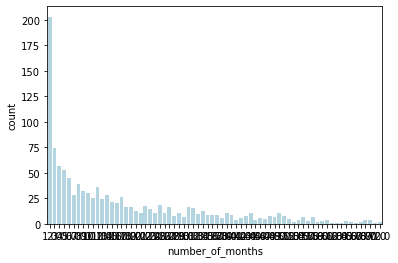

In [14]:
histo = telco.loc[(telco['churn'] == 'Yes') & (telco['contract_type'] == 'Month-to-Month') & (telco['internet_type'] == 'Fiber Optic')].groupby('number_of_months')[['number_of_months']].count()
histo.rename(columns={'number_of_months':'count'}, inplace = True)
histo.reset_index(inplace=True)

sns.barplot(x="number_of_months", y="count", data=histo, color='lightblue')


In [31]:
# sume of churned month-to-month fiber customers with a tenue of 6 months or less
histo2.iloc[0:6]['customer_id'].sum()

460